In [1]:
import random
import numpy as np
import math
from scipy.stats import wasserstein_distance
from scipy.linalg import expm
import matplotlib.pyplot as plt
import ot

In [24]:
# custom rate matrix
def load_sample_rate_matrix():
    W = np.array([[-2, 1, 1], [1, -4, 5], [1, 3, -6]])
#     W = np.array([[-8, 7, 1, 3], [1, -10, 1, 5], [4, 1, -8, 4], [3, 2, 6, -12]])
#     W = np.array([[-1, 1/np.exp(1)], [1, -1/np.exp(1)]])
#     W = np.array([[-1, 1/2], [1, -1/2]])
    return W
load_sample_rate_matrix()

array([[-2,  1,  1],
       [ 1, -4,  5],
       [ 1,  3, -6]])

In [3]:
# read matrix from file
def load_rate_matrix_from_file():
    R = np.loadtxt(open("rate_matrix.csv", "rb"), delimiter=" ", skiprows=0)
    return R

In [4]:
def generate_cost_matrix(N):
    M = np.zeros(shape=(N,N))
    for i in range(N):
        for j in range(N):
            if i != j:
                M[i][j] = 1.0
    return M

In [22]:
# sample next jump time from an exponential distribution
def sample_next_jump_time(scale=1.0):
    return np.random.exponential(scale)

def get_outgoing_propensity(W, curr_state):
    outgoing_propensity = 0
    rate_column_vector = W[:, curr_state]
    for i in range(len(rate_column_vector)):
        if i == curr_state: continue
        outgoing_propensity += rate_column_vector[i]
    return outgoing_propensity
    
# sample from discrete probability distribution
def transition_to_next_state(W, curr_state):
    transition_vector = np.copy(W[:, curr_state])
    # set transition to current state to 0
    transition_vector[curr_state] = 0
    outgoing_propensity = get_outgoing_propensity(W, curr_state)
    
    return np.random.choice(np.arange(len(transition_vector)), 1, p=transition_vector/outgoing_propensity)[0]

def get_velocity_at_time(W, p_prev):    
    rows = len(W)
    cols = len(W[0])
    velocity = 0
    for m in range(cols):
        for n in range(m, rows):
            val = abs(W[n][m]*p_prev[m] - W[m][n]*p_prev[n])
            velocity += val
    return velocity

# compute entropy production rate with respect to time
def compute_entropy_prod_rate(W, curr_prob_vector):
    entropy_prod_rate = np.array([-1]*len(curr_prob_vector))
    for i in range(len(entropy_prod_rate)):
        s = 0
        for j in range(len(W)):
            if ((W[i][j]*curr_prob_vector[j])/(W[j][i]*curr_prob_vector[i]) > 0):
                s += (W[i][j]*curr_prob_vector[j]*math.log((W[i][j]*curr_prob_vector[j])/(W[j][i]*curr_prob_vector[i])))
        entropy_prod_rate[i] = s
    return entropy_prod_rate

In [16]:
def trajectory(T, W):
    t = 1
    times = [t]
    states = [0]
    N = len(W)
    initial_prob = np.array([0]*N)
    initial_prob[0] = 1.0
    
    print("Initial Prob: ", initial_prob, "\n")
    
    traj_prob_list = [initial_prob]
    
    entropy_prod_rate_list = []
    
    avg_velocity_over_time = [1]
    prev_velocity_avg = 0.0
    
    wasserstein_dist_over_time = [0]
    bins = list(range(N))
    M = generate_cost_matrix(N)
    
    itr = 1
    
    while t < T:
        curr_prob_vector = traj_prob_list[-1]        
        W_t = W
        curr_state = states[-1]
        next_state = transition_to_next_state(W_t, curr_state)
        
        print("Iteration number : " , itr)
        
        print("Current state : ", curr_state)
        print("Next state : ", next_state)
    
        next_jump_time = sample_next_jump_time(1/get_outgoing_propensity(W_t, curr_state))
        
        print("Current time of this iteration : ", t)
        print("Rate Factor : ", get_outgoing_propensity(W_t, curr_state))
        print("Next Jump Time : ", next_jump_time)
        
        # NOTE : Bounds are great when the time jump is t = t+1 and not sampled from exponential distribution
#         t = t + next_jump_time
        t = t + 1
                
        times.append(t)
        states.append(next_state)
        
        print("Curr Prob: ", curr_prob_vector, " : ", sum(curr_prob_vector))
    
        # update prob vector
        exp_matrix = expm(t*W_t)
        
        new_prob_vector = np.matmul(exp_matrix, initial_prob)
        traj_prob_list.append(new_prob_vector)
        print("New Prob Vector : ", new_prob_vector, " : ", sum(new_prob_vector))
        

        # NOTE : calculation of current velocity takes e^(rate_matrix) and not rate_matrix, only then current velocity
        # is apporaching zero as p_t reaches equillibrium.
        
        prev_velocity_avg = avg_velocity_over_time[-1]
        current_velocity = get_velocity_at_time(exp_matrix, curr_prob_vector)
        
        new_velocity_avg = (prev_velocity_avg*(itr-1) + current_velocity)/itr
        avg_velocity_over_time.append(new_velocity_avg)
        
        print("Current velocity : ", current_velocity)
        print("Average velocity : ", new_velocity_avg)
        
        current_wass_dist = ot.emd2(initial_prob, new_prob_vector, M)
        wasserstein_dist_over_time.append(current_wass_dist)
        print("Current Wasserstein Distance : ", current_wass_dist)
        
        print("Ratio at time  : ", t, " : ", wasserstein_dist_over_time[-1] / avg_velocity_over_time[-1])

        print("---------")
        
        itr = itr + 1

    return times, states, traj_prob_list, entropy_prod_rate_list, wasserstein_dist_over_time, avg_velocity_over_time

Initial Prob:  [1 0 0 ... 0 0 0] 

Iteration number :  1
Current state :  0
Next state :  1023
Current time of this iteration :  1
Rate Factor :  58.26904160154458
Next Jump Time :  0.02627624890881108
Curr Prob:  [1 0 0 ... 0 0 0]  :  1
New Prob Vector :  [0.00031042 0.00694602 0.00018135 ... 0.00033515 0.06698177 0.08274376]  :  1.0000000000000104
Current velocity :  0.9996895760969167
Average velocity :  0.9996895760969167
Current Wasserstein Distance :  0.9996895760969152
Ratio at time  :  2  :  0.9999999999999986
---------
Iteration number :  2
Current state :  1023
Next state :  127
Current time of this iteration :  2
Rate Factor :  3.689207207289115
Next Jump Time :  0.22590736963177332
Curr Prob:  [0.00031042 0.00694602 0.00018135 ... 0.00033515 0.06698177 0.08274376]  :  1.0000000000000104
New Prob Vector :  [0.0003218  0.00745746 0.00021298 ... 0.0003251  0.07356421 0.07580745]  :  1.0000000000000075
Current velocity :  0.06672590510084475
Average velocity :  0.53320774059888

New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000486
Current velocity :  4.1747717135670676e-13
Average velocity :  0.07189443386873497
Current Wasserstein Distance :  0.9996765404323683
Ratio at time  :  16  :  13.90478353661676
---------
Iteration number :  16
Current state :  862
Next state :  350
Current time of this iteration :  16
Rate Factor :  5.742188331158993
Next Jump Time :  0.07906013496837268
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000486
New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000493
Current velocity :  5.665480038664323e-14
Average velocity :  0.06740103175194256
Current Wasserstein Distance :  0.9996765404323688
Ratio at time  :  17  :  14.831769105723772
---------
Iteration number :  17
Current state :  350
Next state :  382
Current time of this iteration :  17
Rate Factor :  16.8731

Current velocity :  1.516139740063229e-15
Average velocity :  0.03718677613900378
Current Wasserstein Distance :  0.9996765404323266
Ratio at time  :  30  :  26.88258150412249
---------
Iteration number :  30
Current state :  45
Next state :  37
Current time of this iteration :  30
Rate Factor :  8.321070689602832
Next Jump Time :  0.4731032282922173
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000087
New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000564
Current velocity :  1.711770677077999e-15
Average velocity :  0.035947216934370384
Current Wasserstein Distance :  0.9996765404323763
Ratio at time  :  31  :  27.8095670732315
---------
Iteration number :  31
Current state :  37
Next state :  293
Current time of this iteration :  31
Rate Factor :  12.242704756897998
Next Jump Time :  0.027166217178975584
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.074682

New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000109
Current velocity :  2.2125765435054115e-15
Average velocity :  0.024509466091616784
Current Wasserstein Distance :  0.999676540432329
Ratio at time  :  45  :  40.78736504073658
---------
Iteration number :  45
Current state :  860
Next state :  892
Current time of this iteration :  45
Rate Factor :  5.742188331158993
Next Jump Time :  0.060466158908754584
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000109
New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000846
Current velocity :  2.2593696762890795e-15
Average velocity :  0.023964811289580907
Current Wasserstein Distance :  0.9996765404324043
Ratio at time  :  46  :  41.71435060984728
---------
Iteration number :  46
Current state :  892
Next state :  894
Current time of this iteration :  46
Rate Factor :  5.307

Current velocity :  1.8499041918379003e-15
Average velocity :  0.018593388069502816
Current Wasserstein Distance :  0.9996765404318575
Ratio at time  :  59  :  53.76516300821708
---------
Iteration number :  59
Current state :  476
Next state :  220
Current time of this iteration :  59
Rate Factor :  17.69671392142825
Next Jump Time :  0.06009629688333631
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  0.9999999999995385
New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000182
Current velocity :  3.0922053855037688e-15
Average velocity :  0.01827824589883333
Current Wasserstein Distance :  0.999676540432335
Ratio at time  :  60  :  54.69214857735023
---------
Iteration number :  60
Current state :  220
Next state :  156
Current time of this iteration :  60
Rate Factor :  26.436172407646506
Next Jump Time :  0.006590842347078075
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.

New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.000000000000198
Current velocity :  1.4270377315998999e-15
Average velocity :  0.014772828877139578
Current Wasserstein Distance :  0.9996765404325177
Ratio at time  :  74  :  67.66994654486801
---------
Iteration number :  74
Current state :  417
Next state :  425
Current time of this iteration :  74
Rate Factor :  13.658060209785205
Next Jump Time :  0.1026269546933965
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.000000000000198
New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.000000000000246
Current velocity :  1.422320363183679e-15
Average velocity :  0.014573196054475547
Current Wasserstein Distance :  0.9996765404325643
Ratio at time  :  75  :  68.5969321139789
---------
Iteration number :  75
Current state :  425
Next state :  441
Current time of this iteration :  75
Rate Factor :  23.2621834

Current velocity :  2.2864142288284146e-15
Average velocity :  0.012395592046335778
Current Wasserstein Distance :  0.999676540432323
Ratio at time  :  88  :  80.64774451235948
---------
Iteration number :  88
Current state :  129
Next state :  193
Current time of this iteration :  88
Rate Factor :  5.307076314007537
Next Jump Time :  0.9553827085477825
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000000047
New Prob Vector :  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.0746825  0.0746825 ]  :  1.0000000000001517
Current velocity :  2.0753668262471727e-15
Average velocity :  0.012254733045809258
Current Wasserstein Distance :  0.9996765404324714
Ratio at time  :  89  :  81.57473008147902
---------
Iteration number :  89
Current state :  193
Next state :  449
Current time of this iteration :  89
Rate Factor :  7.975571074098723
Next Jump Time :  0.04957471390838916
Curr Prob:  [0.00032346 0.00757445 0.00021902 ... 0.00032346 0.07

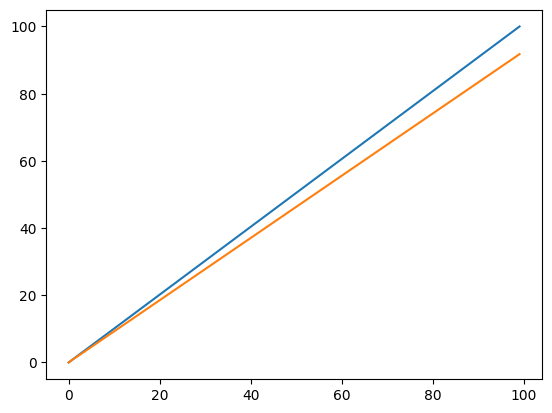

In [27]:
# main loop
num_trajectories = 1

W = load_rate_matrix_from_file()
# W = load_sample_rate_matrix()

# max time
T = 100

for trajectory_idx in range(num_trajectories):
    times, states, traj_prob_list, entropy_prod_rate_list, wasserstein_dist_over_time, avg_velocity_over_time = trajectory(T, W)
    
    plot(wasserstein_dist_over_time, avg_velocity_over_time, T)

In [8]:
# Plot the graph
# verify the bound
def plot(wasserstein_dist_over_time, avg_velocity_over_time, T):    
    time_interval = np.linspace(0, T, len(wasserstein_dist_over_time))
    bound = [i / j for i, j in zip(wasserstein_dist_over_time, avg_velocity_over_time)]
    
    plt.plot(time_interval)
    plt.plot(bound)
    plt.show()

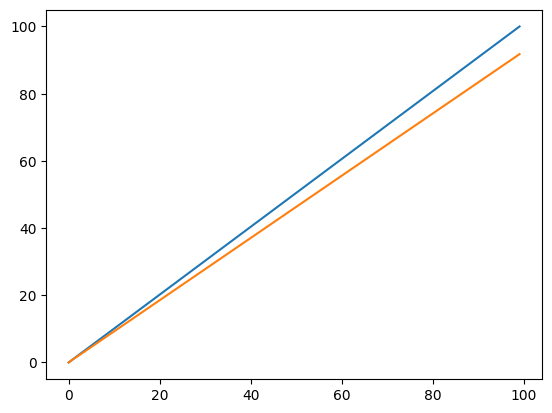

In [31]:
plot(wasserstein_dist_over_time, avg_velocity_over_time, 100)